In [6]:
from collections import Counter
import random
import pandas as pd
import networkx as nx
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns

def run_network_simulation(n_steps, R0, sim_number):
    Gr = nx.read_graphml('03/data/guava.annotated.graphml')

    results = []
    #Initial condition using node attributes
    for node in list(Gr.nodes()): #loop over nodes
        die = random.uniform(0, 1)
        if die<R0:
            Gr.nodes[node]['party'] = 'red'
        else:
            Gr.nodes[node]['party'] = 'blue'

    # loop over time
    for step in range(n_steps):
        for node in list(Gr.nodes()): #loop over nodes
            neighbors = []
            #for neighbor in Gr.neighbors(node): #loop over neighbors
            #for neighbor in Gr.predecessors(node):
            for neighbor in nx.all_neighbors(Gr, node):
                neighbors.append(Gr.nodes[neighbor]["party"])
            if len(neighbors) > 0:
                Gr.nodes[node]["party"] = random.sample(neighbors,1)[0]
        counts = Counter(list(nx.get_node_attributes(Gr, "party").values()))
        results.append({"sim_number": sim_number, "R0": R0, "step": step, "counts": counts})

    results_df = pd.DataFrame.from_dict(results)
    results_df_clean = results_df.drop('counts', axis=1).join(pd.DataFrame(results_df.counts.values.tolist()))
    
    return results_df_clean



# Part A - Guava Model

In [7]:
R0_vals = np.arange(0.10, 1,.10)
repeats = list(range(20))

combos = product(R0_vals, repeats)

In [5]:

runs = [run_network_simulation(1000, R0, n) for R0, n in combos]

runs_pd = pd.concat(runs)

runs_pd["red_prop"] = runs_pd["red"]/(runs_pd["blue"] + runs_pd["red"])
runs_pd_agg = runs_pd.groupby(["step", "R0"]).agg({"red_prop": "mean"}).reset_index()

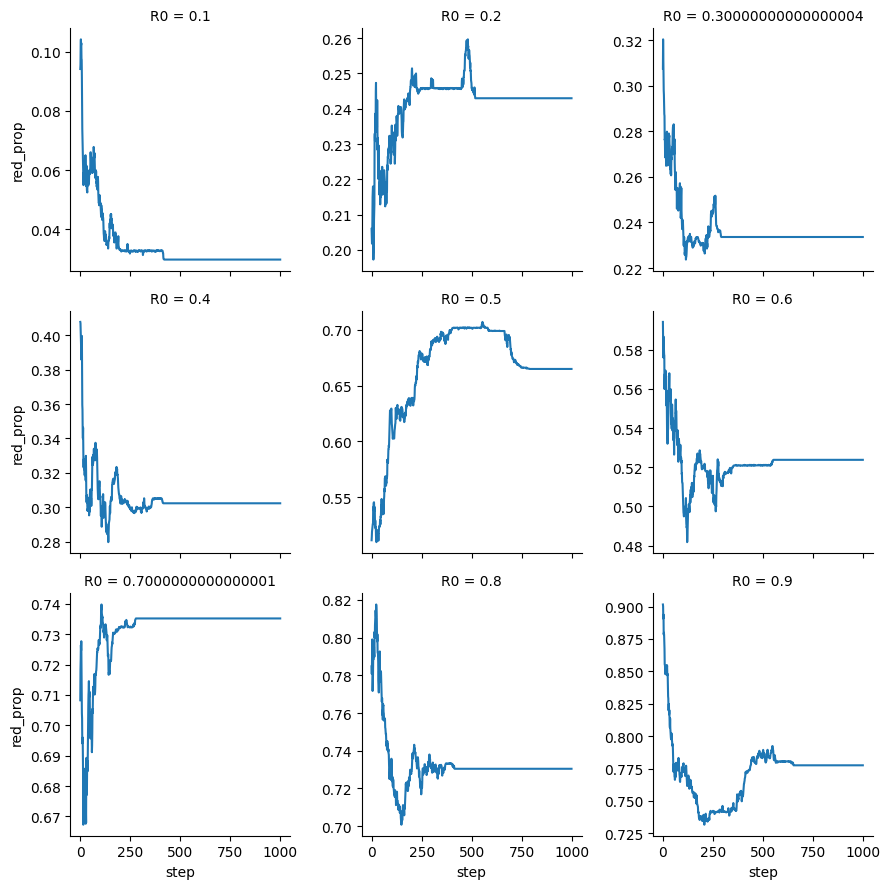

In [10]:
g = sns.FacetGrid(runs_pd_agg, col="R0", col_wrap = 3, sharey=False)
g.map_dataframe(sns.lineplot, x = "step", y = "red_prop")

g.savefig("03/output/base_net_voter.png") 

## Part B - Configuration Model

In [11]:
## https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html

def run_network_simulation_config(n_steps, R0, sim_number):
    Gr = nx.read_graphml('03/data/guava.annotated.graphml')
    Gr_degree_seq = list(dict(Gr.degree()).values())
    Cm = nx.configuration_model(Gr_degree_seq)
    Cm = nx.Graph(Cm)
    Cm.remove_edges_from(nx.selfloop_edges(Cm))

    results = []
    #Initial condition using node attributes
    for node in list(Cm.nodes()): #loop over nodes
        die = random.uniform(0, 1)
        if die<R0:
            Cm.nodes[node]['state'] = 'red'
        else:
            Cm.nodes[node]['state'] = 'blue'

    # loop over time
    for step in range(n_steps):
        for node in list(Cm.nodes()): #loop over nodes
            neighbors = []
            for neighbor in Cm.neighbors(node): #loop over neighbors
                neighbors.append(Cm.nodes[neighbor]["state"])
            if len(neighbors) > 0:
                Cm.nodes[node]["state"] = random.sample(neighbors,1)[0]
        counts = Counter(list(nx.get_node_attributes(Cm, "state").values()))
        results.append({"sim_number": sim_number, "R0": R0, "step": step, "counts": counts})

    results_df = pd.DataFrame.from_dict(results)
    results_df_clean = results_df.drop('counts', axis=1).join(pd.DataFrame(results_df.counts.values.tolist()))
    
    return results_df_clean

In [12]:
runs_nc = [run_network_simulation_config(1000, R0, n) for R0, n in combos]

runs_pd_nc = pd.concat(runs_nc)

runs_pd_nc["red_prop"] = runs_pd_nc["red"]/(runs_pd_nc["blue"] + runs_pd_nc["red"])
runs_pd_nc_agg = runs_pd_nc.groupby(["step", "R0"]).agg({"red_prop": "mean"}).reset_index()

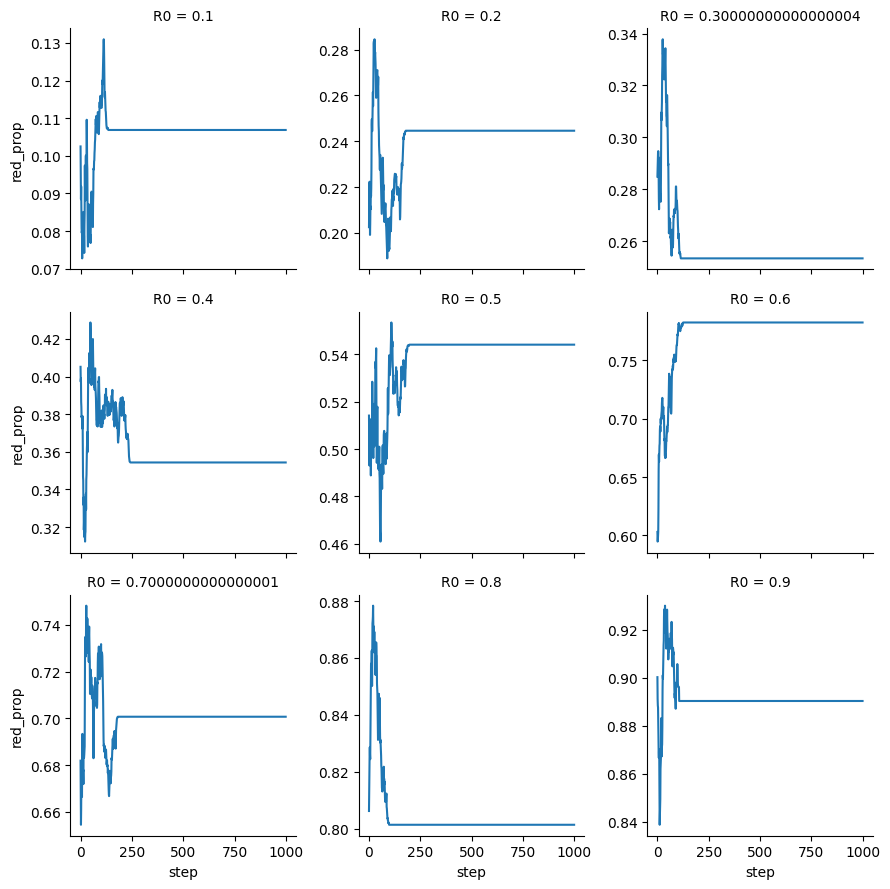

In [15]:
g2 = sns.FacetGrid(runs_pd_nc_agg, col="R0", col_wrap = 3, sharey=False)
g2.map_dataframe(sns.lineplot, x = "step", y = "red_prop")

g2.savefig("03/output/configuration_model_voter.png") 